<a href="https://colab.research.google.com/github/alago1/topological-data-analysis/blob/main/cripser_persistence_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install persim
!pip install -U git+https://github.com/shizuo-kaji/CubicalRipser_3dim
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.7 MB/s 
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18121 sha256=6a107acca190d0fc713c611a4061ce9b84d954f19931add8ad965d9cffe9d0ae
  Stored in directory: /root/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built hopcroftkarp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/shizuo-kaji/CubicalRipser_3dim to /tmp/pip-req-build-0vz7cjmm
  Running command git clone -q https://github.com/shizuo-kaji/CubicalRipser_3dim /tmp/pip-req-build-0vz7cjmm
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cripser: filename=cripser-0.0.8-cp

In [ ]:
# Imported Libraries
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from matplotlib import image
import tcripser as tcr
import persim
import cv2
from PIL import Image
from numpy import asarray
import cripser as cr
import urllib.request
import ipywidgets as wx
from IPython.display import display
from scipy.ndimage import distance_transform_edt
from scipy.ndimage.filters import gaussian_filter

In [ ]:
def sedt(x, zero_boundary=True):
  """Returns the signed euclidean distance transform (EDT) of a binary data array (of any dimension).

  When the boundary is considered zero distance, the EDT for an N-dimensional 
  binary data array computes a new array of equal shape where each cell is the 
  euclidean distance to the nearest boundary 1.

  In the signed EDT, the distance is considered positive if the corresponding 
  cell is outside the object and negative if it's inside.

  Args:
    x: Binary data array (of any dimension).
    zero_boundary: Whether pixels' at the object's boundary should distance 0 (default) or 1.
  
  Returns:
    New data array of signed euclidean distance transform.
  """

  if zero_boundary:
    boundary = distance_transform_edt(x) == 1
    return distance_transform_edt(1 - x) - distance_transform_edt(x - boundary)
  
  return distance_transform_edt(1 - x) - distance_transform_edt(x)

In [ ]:
def show_filtration(im_edt):
  def vis(t):
    plt.imshow(im_edt >= t, vmin = 0, vmax = 1, cmap = 'gray')
  int_plot = wx.interactive(vis,  t = wx.FloatSlider(x=0, min = im_edt.min(), max=im_edt.max(), step = 1./255))
  return wx.HBox([int_plot])

In [ ]:
def compute_persistence_pairs(img):
  """Computes the persistence homology pairs of degree 0, 1, 2.

  Args:
    img: 2D or 3D numpy array of type np.float64
  
  Returns:
    A list where each index (0, 1, 2) is an np.array with the birth-death pairs
      at the respective degree. So at index 0 are the pairs of H_0, index 1 are H_1, etc.
  """
  pd = cr.computePH(img)

  pers_pairs = []
  for d in range(3):
    deg_mask = pd[:,0] == d
    pairs_by_deg = pd[deg_mask][:, 1:3]
    pers_pairs.append(pairs_by_deg)

  return pers_pairs

In [ ]:
def plot_persistence_diagram(persistence_pairs, degree=-1, title='Persistence Diagram Plot'):
  """Plots the persistence diagram given a persistence homology pairs and the desired degrees to be plot.

  Args:
    persistence_pairs: List of ndarrays with birth-death pairs in order of degree.
      So index zero has birth-death pairs of H_0; index 1 of H_1, etc.
    degree: Homologies to consider for the persistance diagram. 
      Can be -1 (all available homologies), 0, 1, 2, or an iterable
      (For instance [0, 1] plots homologies H_0 and H_1)
    title: optional title for the plot

  Returns:
    None
  """

  ALLOWED_DEG = (0, 1, 2)  # only supporting H0, H1, H2

  if degree == -1:
    degree = ALLOWED_DEG

  if type(degree) is int:
    degree = (degree,)

  if any(d not in ALLOWED_DEG for d in degree):
    raise ValueError("Invalid degree. Only supported degrees are 0, 1, 2. Example: degree=(0, 1)")

  for i, d in enumerate(degree):
    if len(persistence_pairs[d]) == 0:
      continue

    point_size = (len(degree) - i) * 20
    persim.plot_diagrams(persistence_pairs[d], size=point_size, labels=f"$H_{i}$", title=title)

In [ ]:
def plot_image_persistence_diagram(img, degree=-1):
  """Shortcut to plot an image and its persistence diagram.

  Args:
    img: ndarray of grayscale img
    degree: Homologies to consider for the persistance diagram. 
      Can be -1 (all available homologies), 0, 1, 2, or an iterable
      (For instance [0, 1] plots homologies H_0 and H_1)
  
  Returns:
    None
  """
  plt.figure()
  f, ax = plt.subplots(1, 2)

  ax[0].set_title("Image")
  ax[0].imshow(img, cmap='gray')
  plt.sca(ax[1])

  pp = compute_persistence_pairs(img)
  plot_persistence_diagram(pp, degree)

  plt.tight_layout()
  plt.show()

In [ ]:
(ims, _), _ = mnist.load_data() 
ims = ims / 255.

In [ ]:
show_filtration(1-ims[675])

<Figure size 640x480 with 0 Axes>

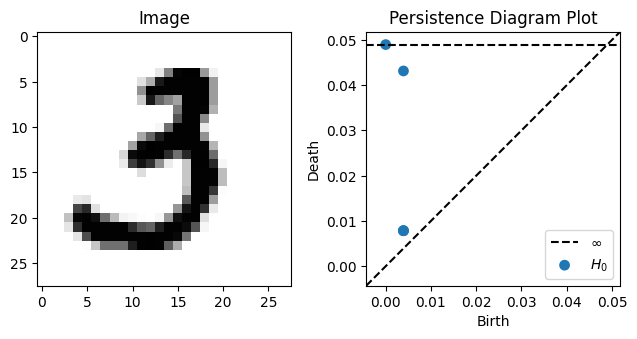

In [ ]:
plot_image_persistence_diagram(1 - ims[675])

In [ ]:
def run_experiments(test_ims, degree=-1):
  for im in test_ims:
    plot_image_persistence_diagram(im, degree=degree)

##Persistence diagrams of raw MNIST images

/usr/local/lib/python3.7/dist-packages/persim/visuals.py:155: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim([x_down, x_up])
/usr/local/lib/python3.7/dist-packages/persim/visuals.py:156: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([y_down, y_up])


<Figure size 640x480 with 0 Axes>

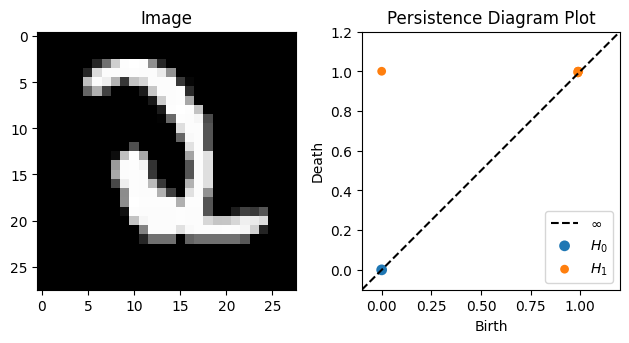

<Figure size 640x480 with 0 Axes>

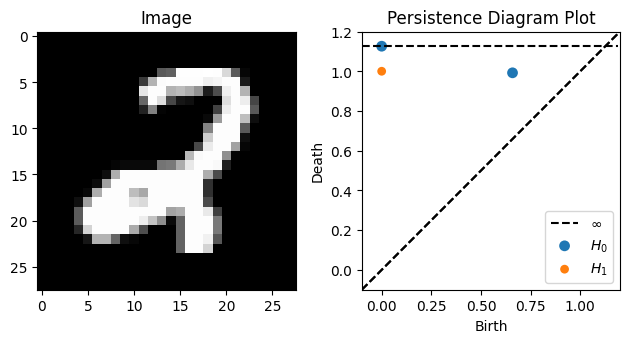

/usr/local/lib/python3.7/dist-packages/persim/visuals.py:155: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim([x_down, x_up])
/usr/local/lib/python3.7/dist-packages/persim/visuals.py:156: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([y_down, y_up])


<Figure size 640x480 with 0 Axes>

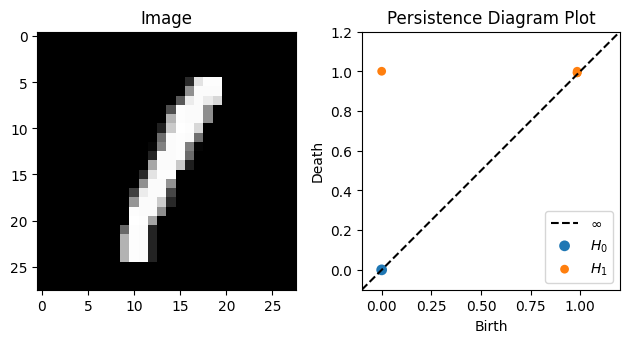

<Figure size 640x480 with 0 Axes>

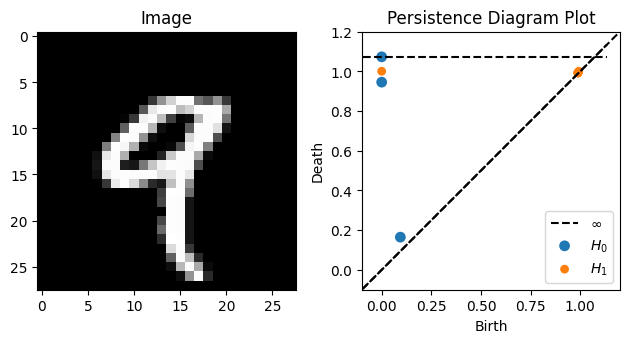

<Figure size 640x480 with 0 Axes>

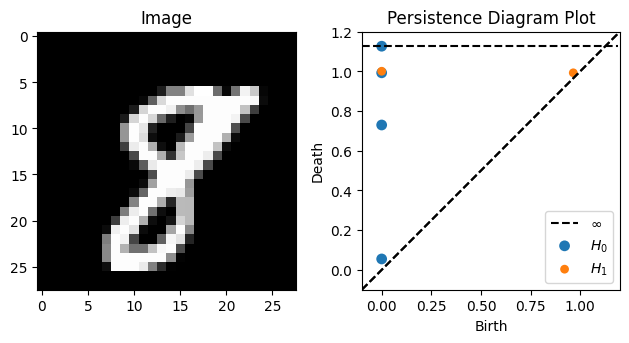

In [ ]:
test_ims = [ims[400], ims[325], ims[77], ims[4], ims[55]]
run_experiments(test_ims)

##Persistence diagrams of sedt-transformed binarized MNIST images

In [ ]:
# Assumes minimum possible pixel value is 0.
# threshold is a percentage of the maximum pixel value
def binarize_im(im, threshold, max_pixel_value=1):
  cutoff = threshold * max_pixel_value

  new_im = im.copy()
  new_im[new_im < cutoff] = 0
  new_im[new_im >= cutoff] = 1
  return new_im

<Figure size 640x480 with 0 Axes>

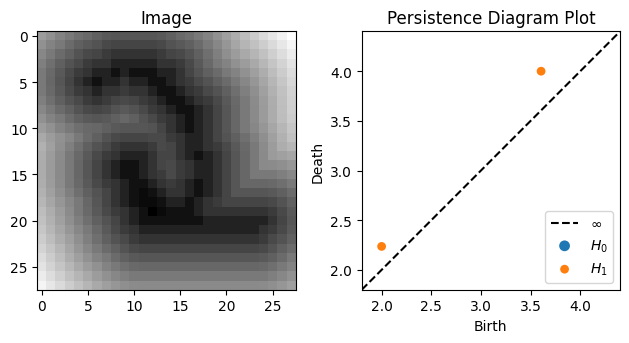

<Figure size 640x480 with 0 Axes>

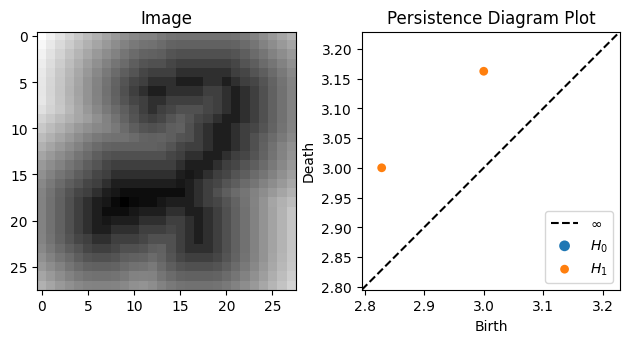

<Figure size 640x480 with 0 Axes>

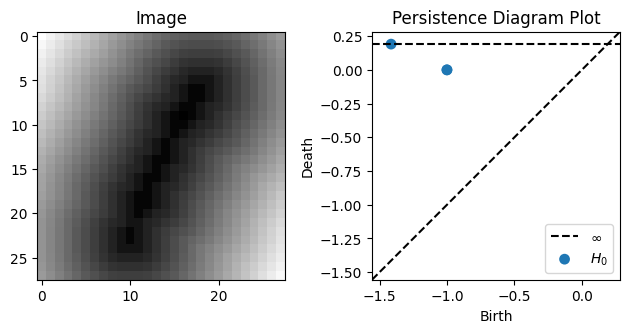

<Figure size 640x480 with 0 Axes>

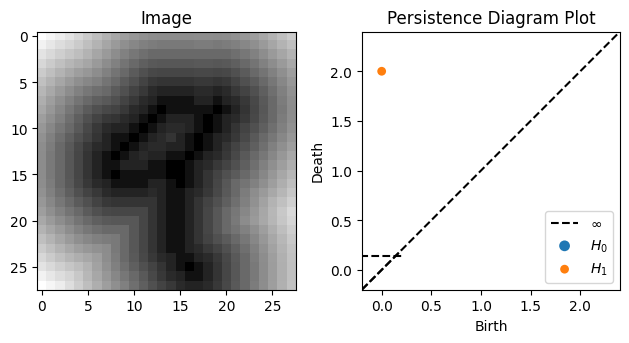

<Figure size 640x480 with 0 Axes>

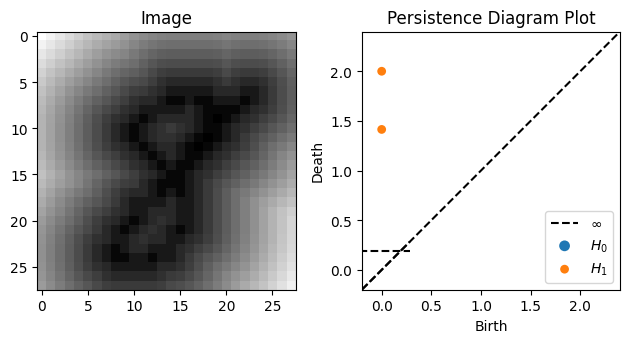

In [ ]:
threshold= 0.5
binarized_ims = [binarize_im(im, threshold=threshold) for im in test_ims]
sedt_transformed_binarized_ims = [sedt(im) for im in binarized_ims]
run_experiments(sedt_transformed_binarized_ims)

##Persistence diagrams of untransformed cifar10 images

In [ ]:
from keras.datasets import cifar10
(cifar_10, _), _ = cifar10.load_data()

<Figure size 640x480 with 0 Axes>

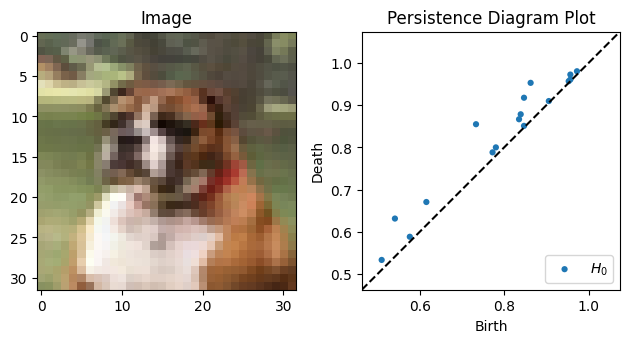

In [ ]:
test_ims = [cifar_10[675]/255.]
run_experiments(test_ims, degree=2)

<Figure size 640x480 with 0 Axes>

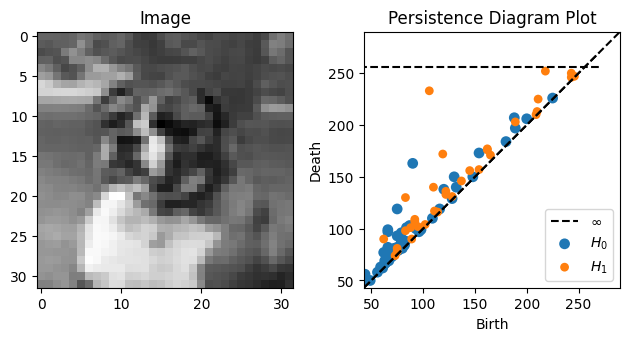

<Figure size 640x480 with 0 Axes>

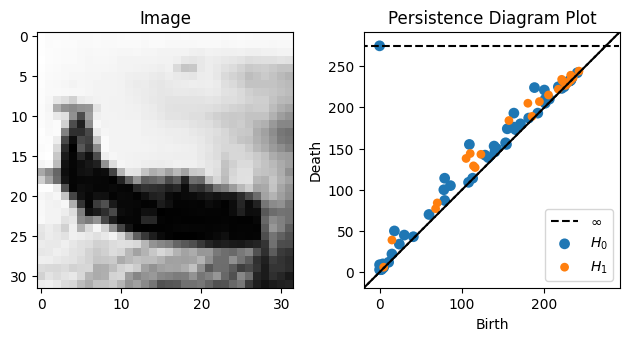

<Figure size 640x480 with 0 Axes>

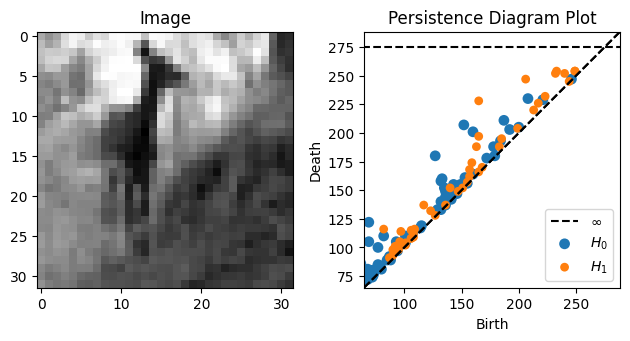

<Figure size 640x480 with 0 Axes>

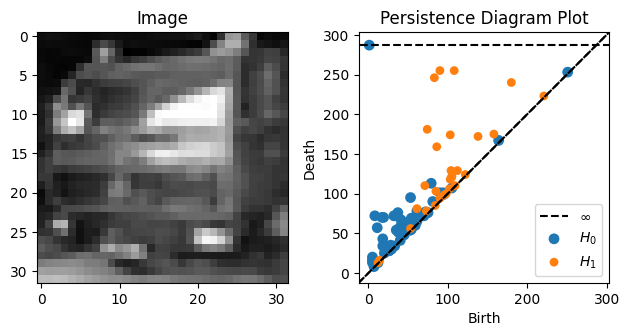

<Figure size 640x480 with 0 Axes>

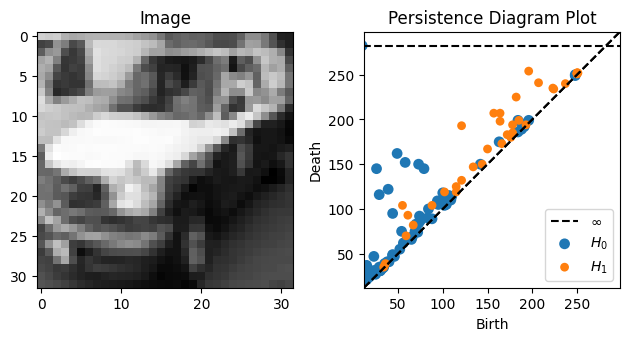

In [ ]:
cifar_10 = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in cifar_10])

test_ims = [cifar_10[675], cifar_10[401], cifar_10[844], cifar_10[357], cifar_10[60]]
run_experiments(test_ims)

##Persistence diagrams of sedt-transformed cifar10 images

<Figure size 640x480 with 0 Axes>

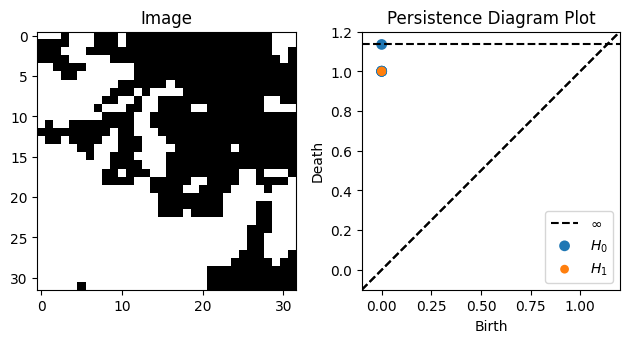

<Figure size 640x480 with 0 Axes>

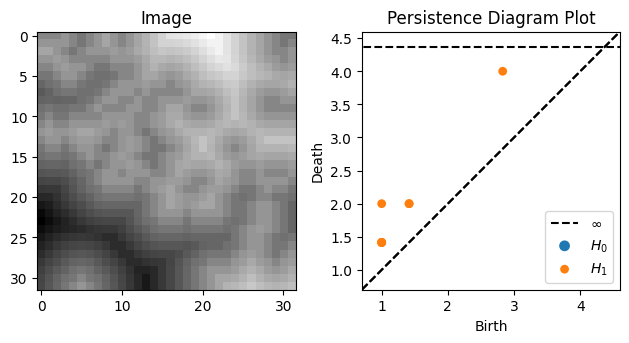

In [ ]:
binarized_im = binarize_im(cifar_10[675]/255, threshold=.40)
run_experiments([binarized_im])

sedt_transformed_binarized_im = sedt(binarized_im)
run_experiments([sedt_transformed_binarized_im])

##Persistence diagrams of other interesting images

In [ ]:
def get_image(url, new_shape=None, new_color_space=None):
  urllib.request.urlretrieve(url, "im.png")
  im = Image.open('im.png')

  if new_shape:
    im = im.resize(new_shape)
  im = asarray(im)

  if new_color_space:
    im = cv2.cvtColor(im, new_color_space)
  im = np.array(im)
  
  return im
  

In [ ]:
urls = ['http://people.clas.ufl.edu/tapeshyadav/files/1_2holes_3components.png',
        'http://people.clas.ufl.edu/tapeshyadav/files/2.png',
        'http://people.clas.ufl.edu/tapeshyadav/files/3.png',
        'http://people.clas.ufl.edu/tapeshyadav/files/3E.png',
        ]
test_ims = []
for url in urls:
  # For black and white image, we get overlapping time of birth and death as nothing new is added as the time progresses. 
  im = get_image(url, new_color_space=cv2.COLOR_BGR2GRAY)
  test_ims.append(im)

urls = ['http://people.clas.ufl.edu/tapeshyadav/files/castle.jpg',
        'http://people.clas.ufl.edu/tapeshyadav/files/bridge.jpg',
        'http://people.clas.ufl.edu/tapeshyadav/files/pattern_wall.jpg',
        'http://people.clas.ufl.edu/tapeshyadav/files/house.jpg',
        ]

for url in urls:
  # For black and white image, we get overlapping time of birth and seath as nothing new is added as the time progresses. 
  im = get_image(url, new_shape=(100,100), new_color_space=cv2.COLOR_BGR2GRAY)
  test_ims.append(im)

<Figure size 640x480 with 0 Axes>

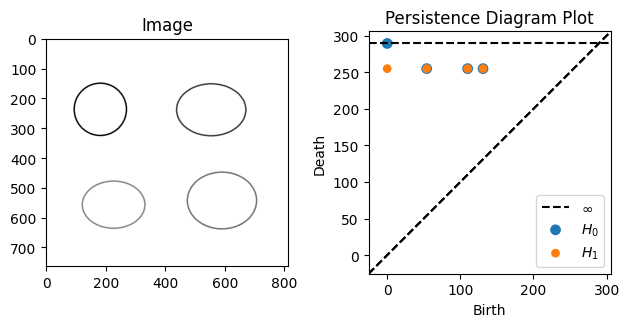

<Figure size 640x480 with 0 Axes>

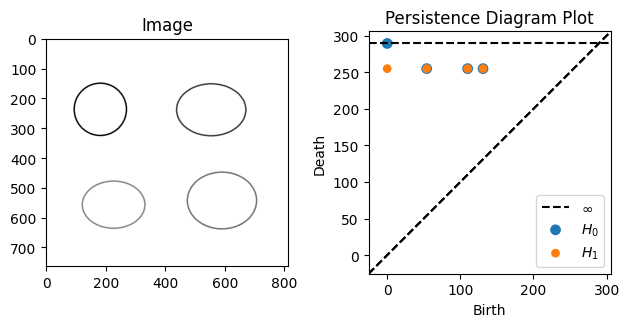

<Figure size 640x480 with 0 Axes>

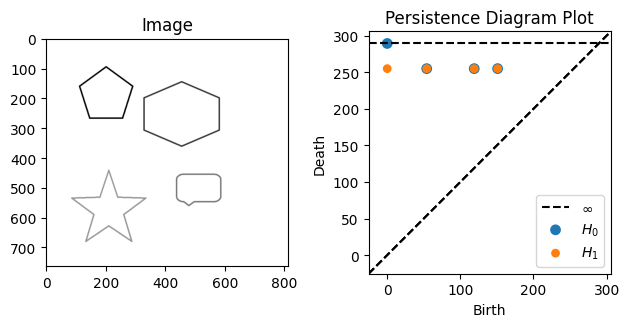

<Figure size 640x480 with 0 Axes>

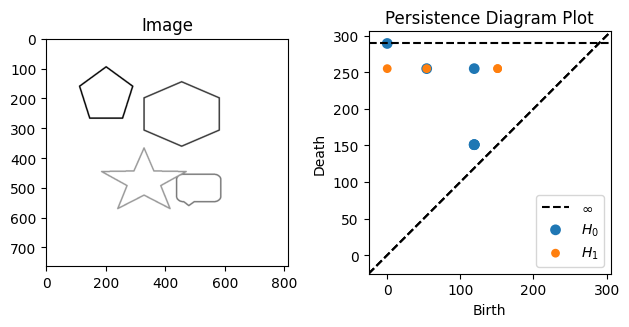

<Figure size 640x480 with 0 Axes>

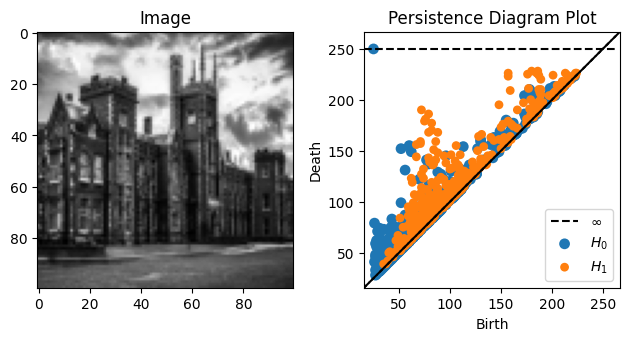

<Figure size 640x480 with 0 Axes>

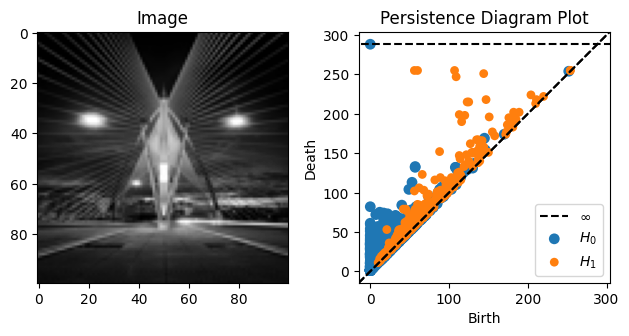

<Figure size 640x480 with 0 Axes>

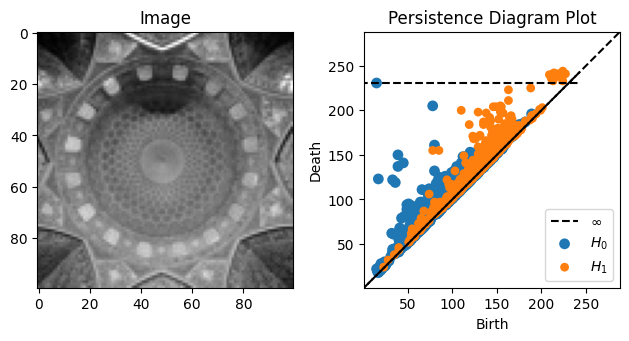

<Figure size 640x480 with 0 Axes>

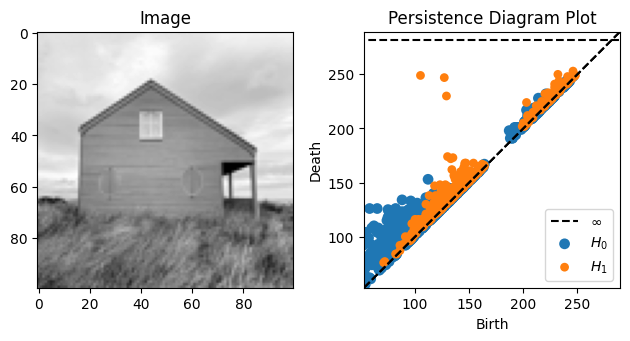

In [ ]:
run_experiments(test_ims)

<Figure size 640x480 with 0 Axes>

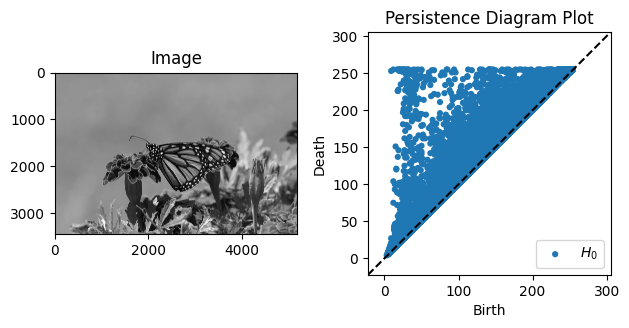

In [ ]:
# For 5184 × 3456 image, the time taken for cripser is around 28 seconds. Overall time taken is 32 sec which include image preprocessing, cripser part (28 sec) and visualization.
im = get_image('http://people.clas.ufl.edu/tapeshyadav/files/butterfly.jpg', new_color_space=cv2.COLOR_BGR2GRAY)
plot_image_persistence_diagram(im, 1)

<Figure size 640x480 with 0 Axes>

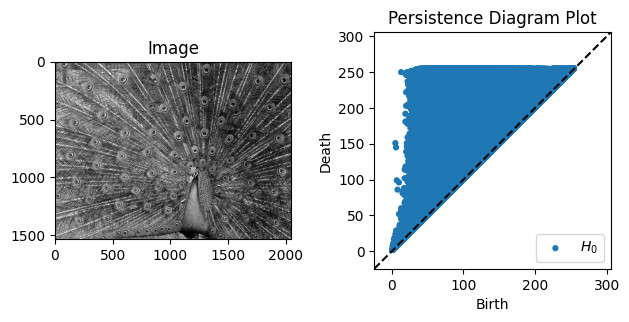

In [ ]:
im = get_image('http://people.clas.ufl.edu/tapeshyadav/files/peacock.jpg', new_color_space=cv2.COLOR_BGR2GRAY)
plot_image_persistence_diagram(im, 1)

## Function to output filtered image along with the persistence diagram

In [ ]:
# experimental code: creating a function which has the same functionality as 
# 'plot_image_persistence_diagram' function but also outputs a filtered image
#  which can give a better understanding of when are components and holes 
# created and deleted from the image.



def plot_image_persistence_diagram_with_filteration(img, degree=-1, show_filter=True):
  """Shortcut to plot an image and its persistence diagram.

  Args:
    img: ndarray of grayscale img
    degree: Homologies to consider for the persistance diagram. 
      Can be -1 (all available homologies), 0, 1, 2, or an iterable
      (For instance [0, 1] plots homologies H_0 and H_1)
    show_filter: Boolean; True outputs filtered image, False do not output filtered image
  
  Returns:
    None
  """

  plt.figure()
  f, ax = plt.subplots(1, 2)

  ax[0].set_title("Image")
  ax[0].imshow(img, cmap='gray')
  plt.sca(ax[1])

  pp = compute_persistence_pairs(img)
  plot_persistence_diagram(pp, degree)

  plt.tight_layout()
  plt.show()

  if show_filter==True:
    display(show_filtration(img))



<Figure size 640x480 with 0 Axes>

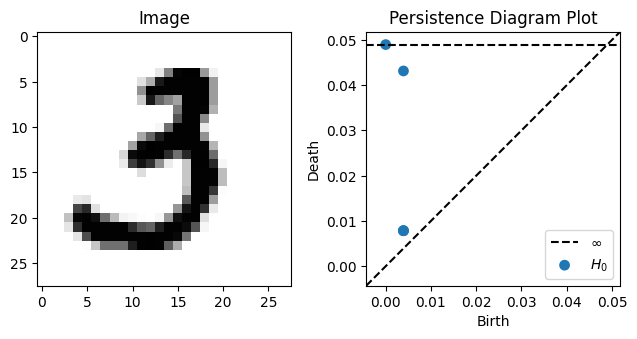

In [ ]:
plot_image_persistence_diagram_with_filteration(1 - ims[675])

## Persistence diagrams for images blurred with Gaussian filter.

In [ ]:
def gaussian_filter_persistence_diagram(im, degree=-1, compare=False, show_filteration=False):
  
  ''' Input image is blurred using Gaussian filter and the persistence diagram for the blurred image is generated.

  Inputs: 
  * im- Input image
  * degree- Degree of the persistence homologies to be shown. Look at the "plot_image_persistence_diagram"
      documentation for more information on the degree variable.
  * compare- If true, the function outputs the persistence diagram for the original image 
      along with the persistence diagem of the blurred image. If compare==False, only 
      blurred image's persistence diagram is displayed.
  * show_filteration: Displays filtered image in addition to the persistence diagram.

  Outputs:
  
  If compare==False, the function outputs the persistence diagram of only the Gaussian blurred image.
  If compare==True, the function outputs persistence diagram for both the blurred and the original image.

  '''
          

  
  # plot_image_persistence_diagram_with_filteration(gaussian_filter(im, sigma=1), degree, show_filteration)
  plot_image_persistence_diagram_with_filteration(gaussian_filter(im, sigma=1),degree=-1)

  if compare==True:
    print('Original Image and its persitence diagram given below:')
    plot_image_persistence_diagram_with_filteration(im, degree, show_filteration)



<Figure size 640x480 with 0 Axes>

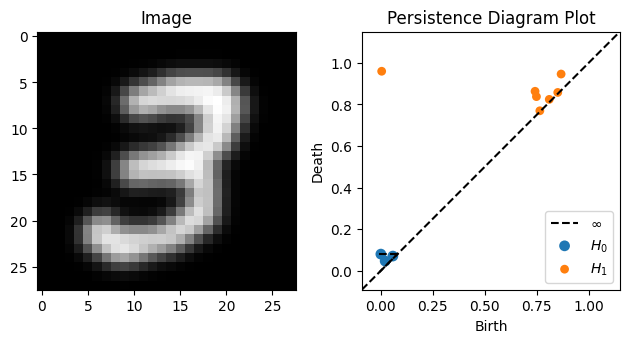

Original Image and its persitence diagram given below:


/usr/local/lib/python3.7/dist-packages/persim/visuals.py:155: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim([x_down, x_up])
/usr/local/lib/python3.7/dist-packages/persim/visuals.py:156: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([y_down, y_up])


<Figure size 640x480 with 0 Axes>

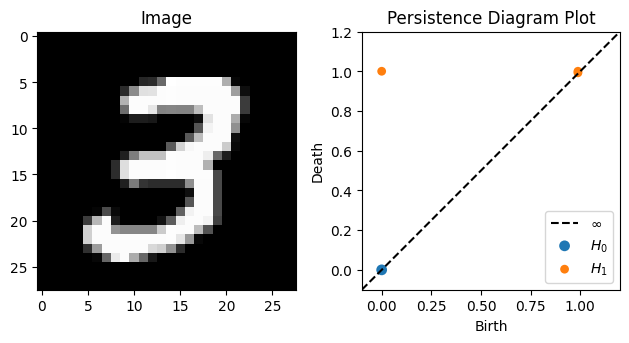

In [ ]:
gaussian_filter_persistence_diagram(ims[7],compare=True, show_filteration=True)

##Notes

In [ ]:
# NOTES:
# Need to visualize multiple data points having same value. Right now, such data points are represented as a single data point.

In [ ]:
# def Persistence_Diagram(im, show_im = False, typeOfViz=1):
#   '''
#   Returns list of shape # of Hole Occurences by 7:
#     0th index -> Dimension of hole
#     1st index -> Birth time
#     2nd index -> Death time

#   Total of 7 values in each list, but unsure of indices 3 to 6...
#   '''
#   pd = cr.computePH(im)

  
#   # Access the lists of holes in accordance with dimensions 0 and 1
#   pds = [pd[pd[:,0] == i] for i in range(3)]

#   # Visualization of image
#   if (show_im):
#     plt.title('Image')
#     plt.imshow(im, cmap = 'gray')
#     plt.show()

#   # Plot persistence diagram
#   print('\nPersistence Diagram Plot')
#   persim.plot_diagrams([p[:,1:3] for p in pds])